In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors as c
from matplotlib import gridspec as grid
import plotly.express as px
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [5]:
df = pd.read_csv('/Users/aravindganesan/Documents/Applied Machine Learning/PROJECT/heart_2020_cleaned.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

# Checking for Null Values

In [7]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

# Heart Disease VS Age Catogery


In [8]:
A1=list(df.groupby('AgeCategory').groups.keys())
B1=[]
C1=[]
for i in A1:
    x=df.loc[(df['AgeCategory']==i),:].loc[df['HeartDisease']=='Yes'].count()['HeartDisease']
    y=df.loc[(df['AgeCategory']==i),].count()['HeartDisease']
    B1+=[x/y]
    C1+=[y]
px.bar(x=B1,y=A1,color=C1,labels = dict(x="Heart disease",y="Age Category"))

In [9]:
A0=['Male','Female']
B0=[] 
C0=[]
for a in A0:
    x=df.loc[(df['Sex']==a),:].loc[df['HeartDisease']=='Yes'].count()['HeartDisease']
    y=df.loc[(df['Sex'] ==a),].count()['HeartDisease']
    B0+=[x/y]
    C0+=[x]
px.bar(A0,B0,color=C0)

In [9]:
#Overall, there are more male adults that have heart disease than female peers.
#Within sample population with heart disease there are more smokers than non-smokers.
#There is no noticeable differences between adults with and without heart disease in being a heavy drinker or having asthma.
#Nevertheless people have heart disease seem to experience stoke and difficulty while walking more than those who don’t.
#Finally people who diagnosed with and without heart disease are slightly distinct in physical activity, diagnosed with kidney disease or skin cancer.

# Encoding Catogerical Variables

In [11]:
t_df = df

#Binary encoding variables: HeartDisease, Smoking, AlcoholDrinking, Stroke, DiffWalking, Sex, Physical Activity, Asthma, KidneyDisease, SkinCancer
binary_cols = ['HeartDisease','Sex','Smoking','AlcoholDrinking','Stroke','Asthma', 'DiffWalking','PhysicalActivity','KidneyDisease','SkinCancer']

for col in binary_cols:
    t_df[col] = t_df[col].replace(list(t_df[col].unique()),[0,1])


#One hot encoding for variables: Race, Diabetic

race_encoder=ce.OneHotEncoder(cols='Race',handle_unknown='return_nan',return_df=True,use_cat_names=True)

diabetic_encoder = ce.OneHotEncoder(cols='Diabetic', handle_unknown='return_nan', return_df=True, use_cat_names=True)

#Ordinal encoding for variables: AgeCategory, GenHealth

age_encoder= ce.OrdinalEncoder(cols=['AgeCategory'],return_df=True,
                           mapping=[{'col':'AgeCategory',
'mapping':{'18-24':0, '25-29':1,'30-34':2,'35-39':3,'40-44':4,'45-49':5,'50-54':6,'55-59':7,'60-64':8,'65-69':9,'70-74':10,'75-79':11,'80 or older':12}}])


health_encoder = ce.OrdinalEncoder(cols=['GenHealth'], return_df=True,
                                    mapping=[{'col':'GenHealth',
                                            'mapping':{'Poor':0,'Fair':1,'Good':2,'Very good':3,'Excellent':4}}])


t_df = age_encoder.fit_transform(t_df)
t_df = health_encoder.fit_transform(t_df)
t_df = race_encoder.fit_transform(t_df)
t_df = diabetic_encoder.fit_transform(t_df)

t_df.head(15)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic_Yes,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes (during pregnancy),PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,0,0,0,3.0,30.0,0,0,7,...,1.0,0.0,0.0,0.0,0,3,5.0,0,0,0
1,0,20.34,1,0,1,0.0,0.0,0,0,12,...,0.0,1.0,0.0,0.0,0,3,7.0,1,0,1
2,0,26.58,0,0,0,20.0,30.0,0,1,9,...,1.0,0.0,0.0,0.0,0,1,8.0,0,0,1
3,0,24.21,1,0,0,0.0,0.0,0,0,11,...,0.0,1.0,0.0,0.0,1,2,6.0,1,0,0
4,0,23.71,1,0,0,28.0,0.0,1,0,4,...,0.0,1.0,0.0,0.0,0,3,8.0,1,0,1
5,1,28.87,0,0,0,6.0,0.0,1,0,11,...,0.0,1.0,0.0,0.0,1,1,12.0,1,0,1
6,0,21.63,1,0,0,15.0,0.0,0,0,10,...,0.0,1.0,0.0,0.0,0,1,4.0,0,0,0
7,0,31.64,0,0,0,5.0,0.0,1,0,12,...,1.0,0.0,0.0,0.0,1,2,9.0,0,0,1
8,0,26.45,1,0,0,0.0,0.0,0,0,12,...,0.0,0.0,1.0,0.0,1,1,5.0,1,1,1
9,0,40.69,1,0,0,0.0,0.0,1,1,9,...,0.0,1.0,0.0,0.0,0,2,10.0,1,0,1


In [13]:
print(t_df.columns)

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race_White', 'Race_Black', 'Race_Asian',
       'Race_American Indian/Alaskan Native', 'Race_Other', 'Race_Hispanic',
       'Diabetic_Yes', 'Diabetic_No', 'Diabetic_No, borderline diabetes',
       'Diabetic_Yes (during pregnancy)', 'PhysicalActivity', 'GenHealth',
       'SleepTime', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')


In [14]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         319795 non-null  int64  
 1   BMI                                  319795 non-null  float64
 2   Smoking                              319795 non-null  int64  
 3   AlcoholDrinking                      319795 non-null  int64  
 4   Stroke                               319795 non-null  int64  
 5   PhysicalHealth                       319795 non-null  float64
 6   MentalHealth                         319795 non-null  float64
 7   DiffWalking                          319795 non-null  int64  
 8   Sex                                  319795 non-null  int64  
 9   AgeCategory                          319795 non-null  int64  
 10  Race_White                           319795 non-null  float64
 11  Race_Black   

In [15]:
t_df.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic_Yes,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes (during pregnancy),PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,...,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.587523,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,6.514536,...,0.127588,0.843206,0.021204,0.008002,0.224638,2.595028,7.097075,0.865939,0.036833,0.906756
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,3.564759,...,0.333631,0.363607,0.144065,0.089095,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,6.000000,1.000000,0.000000,1.000000
50%,0.000000,27.340000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,7.000000,1.000000,0.000000,1.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,9.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,8.000000,1.000000,0.000000,1.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


In [14]:
# Normalizing data
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# names = t_df.columns
# d = scaler.fit_transform(t_df)

# scaled_df = pd.DataFrame(d, columns=names)


# scaled_df.head() 

In [16]:
print('Continuous Columns')
df.select_dtypes(include=['float']).describe().T[['min', 'mean', 'max']].style.background_gradient(cmap='Blues')

Continuous Columns


,min,mean,max
BMI,12.020000,28.325399,94.850000
PhysicalHealth,0.000000,3.371710,30.000000
MentalHealth,0.000000,3.898366,30.000000
SleepTime,1.000000,7.097075,24.000000


In [17]:
for col in ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']:
    t_df[col] = t_df[col]/t_df[col].max()

In [35]:
t_df[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']]

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,0.175013,0.100000,1.0,0.208333
1,0.214444,0.000000,0.0,0.291667
2,0.280232,0.666667,1.0,0.333333
3,0.255245,0.000000,0.0,0.250000
4,0.249974,0.933333,0.0,0.333333
...,...,...,...,...
319790,0.288983,0.233333,0.0,0.250000
319791,0.314602,0.000000,0.0,0.208333
319792,0.255561,0.000000,0.0,0.250000
319793,0.345915,0.000000,0.0,0.500000


In [38]:
np.round(t_df[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']].describe(),3)

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000,319795.000,319795.000,319795.000
mean,0.299,0.112,0.130,0.296
std,0.067,0.265,0.265,0.060
min,0.127,0.000,0.000,0.042
25%,0.253,0.000,0.000,0.250
50%,0.288,0.000,0.000,0.292
75%,0.331,0.067,0.100,0.333
max,1.000,1.000,1.000,1.000


In [18]:
t_df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic_Yes,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes (during pregnancy),PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,0.175013,0,0,0,0.100000,1.0,0,0,7,...,1.0,0.0,0.0,0.0,0,3,0.208333,0,0,0
1,0,0.214444,1,0,1,0.000000,0.0,0,0,12,...,0.0,1.0,0.0,0.0,0,3,0.291667,1,0,1
2,0,0.280232,0,0,0,0.666667,1.0,0,1,9,...,1.0,0.0,0.0,0.0,0,1,0.333333,0,0,1
3,0,0.255245,1,0,0,0.000000,0.0,0,0,11,...,0.0,1.0,0.0,0.0,1,2,0.250000,1,0,0
4,0,0.249974,1,0,0,0.933333,0.0,1,0,4,...,0.0,1.0,0.0,0.0,0,3,0.333333,1,0,1
5,1,0.304375,0,0,0,0.200000,0.0,1,0,11,...,0.0,1.0,0.0,0.0,1,1,0.500000,1,0,1
6,0,0.228044,1,0,0,0.500000,0.0,0,0,10,...,0.0,1.0,0.0,0.0,0,1,0.166667,0,0,0
7,0,0.333579,0,0,0,0.166667,0.0,1,0,12,...,1.0,0.0,0.0,0.0,1,2,0.375000,0,0,1
8,0,0.278861,1,0,0,0.000000,0.0,0,0,12,...,0.0,0.0,1.0,0.0,1,1,0.208333,1,1,1
9,0,0.428993,1,0,0,0.000000,0.0,1,1,9,...,0.0,1.0,0.0,0.0,0,2,0.416667,1,0,1


0    292422
1     27373
Name: HeartDisease, dtype: int64

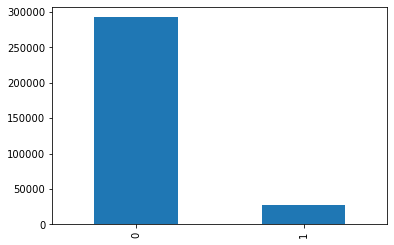

In [19]:
t_df.HeartDisease.value_counts().plot(kind="bar")
t_df.HeartDisease.value_counts()
#0.08 only 8% of the entire data is 1
#since the dataset is undersampled with many data for adults without heart disease, lets oversample the data to make it more balanced

# Balancing the dataset

After undersampling: Counter({0: 54746, 1: 27373})


([<matplotlib.patches.Wedge at 0x7fe2d2859850>,
 [Text(-0.5500000594609754, 0.95262790983307, 'No'),
  Text(0.5500001486524351, -0.9526278583383437, 'Yes')],
 [Text(-0.3000000324332593, 0.5196152235453109, '67%'),
  Text(0.3000000810831464, -0.5196151954572784, '33%')])

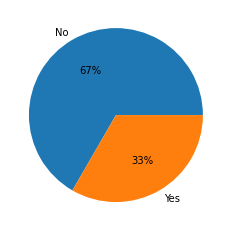

In [20]:
from collections import Counter
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
x = t_df.iloc[:, 1:] # Remove target variable
y = t_df['HeartDisease']
x_under, y_under = under_sampler.fit_resample(x, y)

# Count classes and create pie chart
print(f'After undersampling: {Counter(y_under)}')
plt.pie(y_under.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%')

After oversampling: Counter({0: 292422, 1: 292422})


([<matplotlib.patches.Wedge at 0x7fe2d27eadc0>,
 [Text(6.735557395310444e-17, 1.1, 'No'),
  Text(-2.0206672185931328e-16, -1.1, 'Yes')],
 [Text(3.6739403974420595e-17, 0.6, '50%'),
  Text(-1.1021821192326178e-16, -0.6, '50%')])

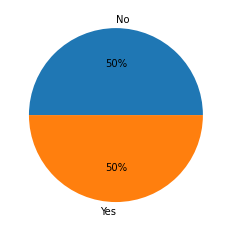

In [21]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = over_sampler.fit_resample(x, y)

# Count classes and create pie chart
print(f'After oversampling: {Counter(y_over)}')
plt.pie(y_over.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%')

In [22]:
fig = px.imshow(t_df[['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
                    'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer','BMI', 'PhysicalHealth',
                    'MentalHealth', 'AgeCategory', 'SleepTime']].corr(),color_continuous_scale="Blues")
fig.update_layout(height=800)
fig.show()

# Evaluate a given model using cross-validation

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def evaluate_model(model, X, y):
	# define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
	# evaluate the model and collect the results
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return n_scores


# Data Split


In [24]:
from sklearn.model_selection import train_test_split
X, y = x_over, y_over
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Selection

In [25]:
XGBoost = XGBClassifier()
XG_model = XGBoost.fit(X_train, y_train)

In [40]:
feature_importance = {'Feature':X_train.columns,'Importance':XG_model.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
feature_importance

ValueError: All arrays must be of the same length

### Choosing features greater than 1%

In [27]:
final_features = feature_importance["Feature"][feature_importance.Importance > 0.01]
X_train = X_train[final_features]
X_test = X_test[final_features]

In [28]:
X_train[final_features]

,AgeCategory,GenHealth,Stroke,Sex,DiffWalking,Diabetic_Yes,KidneyDisease,Smoking,Diabetic_No,Race_White,Asthma,AlcoholDrinking,PhysicalHealth,Diabetic_Yes (during pregnancy),Race_Black,"Diabetic_No, borderline diabetes",Race_Hispanic,SkinCancer,Race_Asian,SleepTime
425757,6,1,1,1,1,0.0,0,0,1.0,1.0,1,0,0.000000,0.0,0.0,0.0,0.0,1,0.0,0.333333
525767,12,1,0,1,0,0.0,0,0,1.0,1.0,1,0,1.000000,0.0,0.0,0.0,0.0,1,0.0,0.375000
113093,8,2,0,1,0,1.0,0,0,0.0,1.0,1,0,0.000000,0.0,0.0,0.0,0.0,1,0.0,0.333333
334184,12,2,0,1,0,1.0,0,0,0.0,1.0,1,0,0.100000,0.0,0.0,0.0,0.0,0,0.0,0.333333
194194,3,3,0,0,0,0.0,0,1,1.0,0.0,1,0,0.000000,0.0,0.0,0.0,1.0,1,0.0,0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,10,3,0,1,0,1.0,0,0,0.0,1.0,1,0,0.000000,0.0,0.0,0.0,0.0,1,0.0,0.291667
152315,4,3,0,1,0,0.0,0,1,1.0,1.0,1,0,0.000000,0.0,0.0,0.0,0.0,1,0.0,0.333333
117952,2,2,0,0,0,0.0,0,1,1.0,0.0,1,0,0.266667,0.0,0.0,0.0,1.0,1,0.0,0.291667
435829,10,1,0,0,1,0.0,0,0,1.0,1.0,0,0,0.000000,0.0,0.0,0.0,0.0,1,0.0,0.291667


In [29]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
table = pd.DataFrame(columns = ["Num Trees", "Learning Rate","Tree Depth", "AUC Train", "AUC Test"])

row = 0
for num_trees in [10, 20, 50, 100]:
  for LR in [0.01, 0.1,0.2]:
    for MD in [7,9]:
      xgb_instance = xgb.XGBClassifier(n_estimators=num_trees, learning_rate = LR, max_depth = MD)
      model = xgb_instance.fit(X_train, y_train)
      table.loc[row,"Num Trees"] = num_trees
      table.loc[row,"Learning Rate"] = LR
      table.loc[row,"Tree Depth"] = MD
      table.loc[row,"AUC Train"] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
      table.loc[row,"AUC Test"] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
      row = row + 1
table

,Num Trees,Learning Rate,Tree Depth,AUC Train,AUC Test
0,10,0.01,7,0.836432,0.835373
1,10,0.01,9,0.84517,0.8426
2,10,0.1,7,0.842134,0.840718
3,10,0.1,9,0.851143,0.847848
4,10,0.2,7,0.846524,0.844363
5,10,0.2,9,0.855828,0.851582
6,20,0.01,7,0.837418,0.83629
7,20,0.01,9,0.84608,0.843416
8,20,0.1,7,0.846945,0.844982
9,20,0.1,9,0.85587,0.851846


In [30]:
table.sort_values("AUC Test", inplace=True,ascending=False)
table

,Num Trees,Learning Rate,Tree Depth,AUC Train,AUC Test
23,100,0.2,9,0.88798,0.877221
21,100,0.1,9,0.874289,0.866611
17,50,0.2,9,0.874807,0.86647
15,50,0.1,9,0.866256,0.860148
22,100,0.2,7,0.865154,0.859439
11,20,0.2,9,0.863472,0.857816
20,100,0.1,7,0.857755,0.853696
16,50,0.2,7,0.85757,0.853428
9,20,0.1,9,0.85587,0.851846
5,10,0.2,9,0.855828,0.851582


# Final Model

In [31]:
xgb_instance = xgb.XGBClassifier(n_estimators=100, learning_rate = 0.2,max_depth=9,subsample=0.5)
final_model = xgb_instance.fit(X_train, y_train)
XGBoost_pred = xgb_instance.predict(X_test)
XGBoost_matrix = confusion_matrix(y_test, XGBoost_pred, labels=[0, 1])

import warnings
warnings.filterwarnings('ignore')
print('Final XGBoost Model is Created!')

Final XGBoost Model is Created!


>Accuracy 0.818 (0.001)


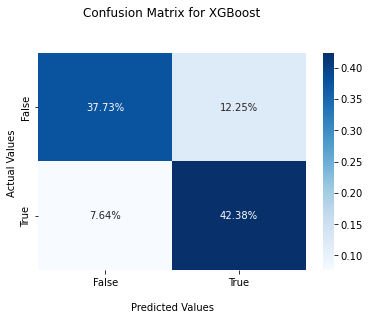

In [32]:
from numpy import mean
from numpy import std

ax = sns.heatmap(XGBoost_matrix/np.sum(XGBoost_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for XGBoost\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
scores = evaluate_model(xgb_instance, X, y)
print('>%s %.3f (%.3f)' % ('Accuracy', mean(scores), std(scores)))
plt.show()

In [52]:
X_test

,GenHealth,AgeCategory,Stroke,Sex,DiffWalking,Diabetic_Yes,Smoking,KidneyDisease,Diabetic_No,Race_White,Asthma,PhysicalHealth,AlcoholDrinking,Race_Hispanic,Diabetic_Yes (during pregnancy),Race_Asian,Race_Black,SleepTime,SkinCancer
114267,4,4,0,1,0,0.0,1,0,1.0,0.0,1,0.000000,0,0.0,0.0,0.0,1.0,0.250000,1
364804,1,6,0,1,0,0.0,0,0,0.0,0.0,1,0.066667,0,1.0,0.0,0.0,0.0,0.291667,1
230608,3,9,0,1,0,0.0,1,0,1.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.333333,1
274445,3,0,0,1,0,0.0,1,0,1.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.333333,1
76729,2,9,0,0,0,0.0,1,0,1.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38403,2,1,0,0,0,0.0,1,0,1.0,0.0,1,0.000000,0,1.0,0.0,0.0,0.0,0.333333,1
151789,2,10,0,1,1,0.0,1,0,0.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.375000,1
203384,2,8,0,1,0,0.0,0,0,1.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.166667,1
517085,2,11,0,1,0,0.0,1,0,1.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.375000,0


In [53]:
y_test

114267    0
364804    1
230608    1
274445    0
76729     0
         ..
38403     0
151789    0
203384    1
517085    1
133739    0
Name: HeartDisease, Length: 116969, dtype: int64

In [54]:
XGBoost_pred

array([0, 1, 1, ..., 1, 1, 0])

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, XGBoost_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     58461
           1       0.78      0.85      0.81     58508

    accuracy                           0.80    116969
   macro avg       0.80      0.80      0.80    116969
weighted avg       0.80      0.80      0.80    116969



# Top 10 most important features

# SHAP Analysis

### SHAP Summary Plot

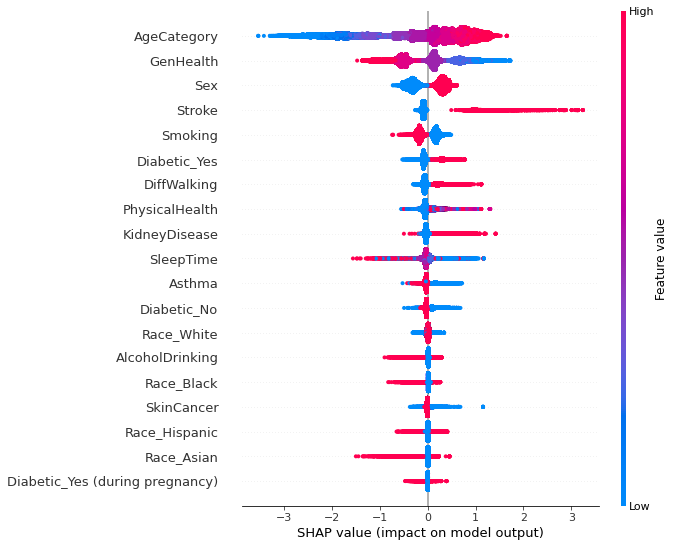

In [34]:
import shap

shap_values = shap.TreeExplainer(xgb_instance).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

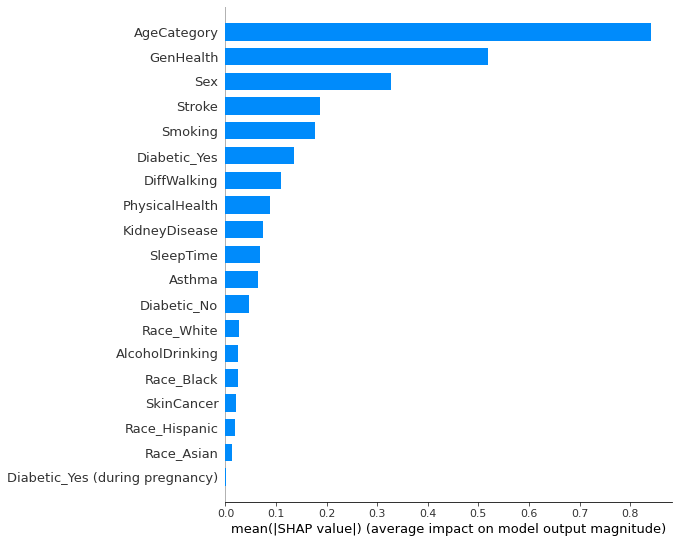

In [35]:
import shap

shap_values = shap.TreeExplainer(xgb_instance).shap_values(X_train)
shap.summary_plot(shap_values, X_train,plot_type="bar")

### SHAP Dependence Plot for 3 most important variables

#### Age Catogery

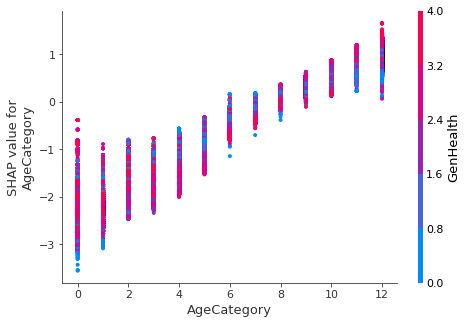

In [36]:
shap.dependence_plot("AgeCategory", shap_values, X_train)


#### General Health

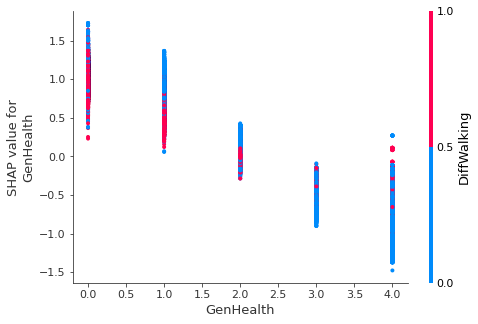

In [37]:
shap.dependence_plot("GenHealth", shap_values, X_train)

#### Sex

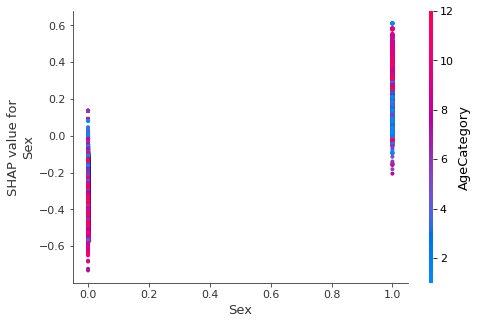

In [38]:
shap.dependence_plot("Sex", shap_values, X_train)

### Individual SHAP Value Plot

In [39]:
shap.initjs()

In [40]:
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_test.iloc[random_picks]
S

,GenHealth,AgeCategory,Stroke,Sex,DiffWalking,Diabetic_Yes,Smoking,KidneyDisease,Diabetic_No,Race_White,Asthma,PhysicalHealth,AlcoholDrinking,Race_Hispanic,Diabetic_Yes (during pregnancy),Race_Asian,Race_Black,SleepTime,SkinCancer
364804,1,6,0,1,0,0.0,0,0,0.0,0.0,1,0.066667,0,1.0,0.0,0.0,0.0,0.291667,1
524660,0,7,0,1,1,0.0,0,0,1.0,1.0,0,0.666667,0,0.0,0.0,0.0,0.0,0.250000,1
207748,4,1,0,0,0,0.0,1,0,1.0,0.0,1,0.000000,0,0.0,0.0,1.0,0.0,0.291667,1
339556,1,9,1,1,1,0.0,1,0,1.0,1.0,1,0.166667,0,0.0,0.0,0.0,0.0,0.291667,1
351940,0,11,0,1,1,0.0,0,0,1.0,1.0,1,1.000000,0,0.0,0.0,0.0,0.0,0.166667,1
349980,2,10,0,1,1,1.0,0,1,0.0,1.0,1,0.000000,0,0.0,0.0,0.0,0.0,0.250000,1
532760,1,10,0,1,1,0.0,0,0,1.0,0.0,1,1.000000,0,0.0,0.0,0.0,1.0,0.333333,1


In [41]:
# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xgb_instance)
    shap_values_Model = explainerModel.shap_values(X_test)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [42]:
shap_plot(1)

In [55]:

from sklearn.model_selection import GridSearchCV
parameters=[{'n_estimators':[10,20,50,100], 'max_depth':  
             [1,2,3,4,5,6,7,8,9], 'learning_rate':[0.1,0.01,0.2]},
             ]
             
grid_search = GridSearchCV(estimator=XGBoost,
                           param_grid=parameters,
                           cv=10,
                           n_jobs=-1)
                           
grid = grid_search.fit(X_train,y_train)
grid.best_score_

0.7961357320701602

In [56]:
grid.best_params_

{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100}

In [ ]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

In [ ]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

In [ ]:
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=25, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)
nn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1)